# Lab Three - Extending Logistic Regression

Use Sex, Age, country, and marital-status to predict education

## Preperation and Overview
### Business Case
WIP
### Pre-Processing the Data

In [13]:
import pandas as pd
import numpy as np
import missingno as mn

initData = pd.read_csv('/home/tommy/Downloads/abalone.data')
initData.groupby(['Rings']).size()
duplicates = initData.duplicated().loc[initData.duplicated() == True].count()
print("Number of duplicate values: ", duplicates)
print("Missing Values Present: ", initData.isnull().values.sum())
initData.info()

Number of duplicate values:  0
Missing Values Present:  0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole-Weight    4177 non-null   float64
 5   Shucked-Weight  4177 non-null   float64
 6   Viscera-Weight  4177 non-null   float64
 7   Shell-Weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [14]:
print(initData.groupby(['Rings']).size())
initData.head()

Rings
1       1
2       1
3      15
4      57
5     115
6     259
7     391
8     568
9     689
10    634
11    487
12    267
13    203
14    126
15    103
16     67
17     58
18     42
19     32
20     26
21     14
22      6
23      9
24      2
25      1
26      1
27      2
29      1
dtype: int64


,Sex,Length,Diameter,Height,Whole-Weight,Shucked-Weight,Viscera-Weight,Shell-Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Before I use the data, I first one hot encode the sex class. Under normal circumstances, this would yield a single binary attribute; however, there are three unique values for sex in the dataset: male, female, and infant, so instead three attributes will be needed. I'm also discretizing the the number of rings into three ranges.

In [15]:
# One Hot Encoding Sex
temp = pd.get_dummies(initData['Sex'])
initData = pd.concat([initData, temp], axis=1).drop('Sex', axis=1)
initData.rename(columns={'F': 'Female', 'M': 'Male','I': 'Infant'}, inplace = True)

#Discretizing Ring Size
initData['Ring-Range'] = pd.cut(initData['Rings'],[0,8,10,30],
                                 labels=['1-8','9-10','11-30']) 
#initData['Ring-Range'] = initData['Ring-Range'].astype('uint8')
del initData['Rings']
initData.head()

,Length,Diameter,Height,Whole-Weight,Shucked-Weight,Viscera-Weight,Shell-Weight,Female,Infant,Male,Ring-Range
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0,0,1,11-30
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,0,1,1-8
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1,0,0,9-10
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0,0,1,9-10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,1,0,1-8


I realize that 1-8, 9-10, and 11-30, are odd choices for ring ranges, but I wanted to ensure the number of entries per range was as similar as possible.

In [16]:
print(initData.groupby(['Ring-Range']).size())

Ring-Range
1-8      1407
9-10     1323
11-30    1447
dtype: int64


Next, I'll scale all the continuous variables, so that they rest between 0 and 1.

In [17]:
continuous_vars = ['Length', 'Diameter', 'Height', 'Whole-Weight', 'Shucked-Weight', 'Viscera-Weight', 'Shell-Weight']
for v in continuous_vars:
    # Taken from: https://www.geeksforgeeks.org/normalize-a-column-in-pandas/
    initData[v] = (initData[v]-initData[v].min())/(initData[v].max()-initData[v].min())

initData.head()

,Length,Diameter,Height,Whole-Weight,Shucked-Weight,Viscera-Weight,Shell-Weight,Female,Infant,Male,Ring-Range
0,0.513514,0.521008,0.084071,0.181335,0.150303,0.132324,0.147982,0,0,1,11-30
1,0.371622,0.352941,0.079646,0.079157,0.066241,0.063199,0.068261,0,0,1,1-8
2,0.614865,0.613445,0.119469,0.239065,0.171822,0.185648,0.207773,1,0,0,9-10
3,0.493243,0.521008,0.110619,0.182044,0.144250,0.149440,0.152965,0,0,1,9-10
4,0.344595,0.336134,0.070796,0.071897,0.059516,0.051350,0.053313,0,1,0,1-8


In [18]:
initData.describe()

,Length,Diameter,Height,Whole-Weight,Shucked-Weight,Viscera-Weight,Shell-Weight,Female,Infant,Male
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.606746,0.593078,0.123466,0.292808,0.241000,0.237121,0.236503,0.312904,0.321283,0.365813
std,0.162288,0.166790,0.037015,0.173681,0.149269,0.144324,0.138717,0.463731,0.467025,0.481715
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.506757,0.495798,0.101770,0.155658,0.124412,0.122449,0.128052,0.000000,0.000000,0.000000
50%,0.635135,0.621849,0.123894,0.282451,0.225286,0.224490,0.231689,0.000000,0.000000,0.000000
75%,0.729730,0.714286,0.146018,0.407650,0.336920,0.332456,0.326358,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
initData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Length          4177 non-null   float64 
 1   Diameter        4177 non-null   float64 
 2   Height          4177 non-null   float64 
 3   Whole-Weight    4177 non-null   float64 
 4   Shucked-Weight  4177 non-null   float64 
 5   Viscera-Weight  4177 non-null   float64 
 6   Shell-Weight    4177 non-null   float64 
 7   Female          4177 non-null   uint8   
 8   Infant          4177 non-null   uint8   
 9   Male            4177 non-null   uint8   
 10  Ring-Range      4177 non-null   category
dtypes: category(1), float64(7), uint8(3)
memory usage: 245.0 KB


WIP, describe the data

### Splitting the Data

In [20]:
from sklearn import model_selection as ms

y = initData['Ring-Range'].values
X = initData.drop('Ring-Range', axis=1).to_numpy()


X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2)

# temp2 = y_train.to_numpy()
# count1 = (temp2 == '1-8').sum()
# count2 = (temp2 == '9-10').sum()
# count3 = (temp2 == '11-30').sum()
# print(count1, '|', count2, '|', count3)
# temp2 = y_test.to_numpy()
# count1 = (temp2 == '1-8').sum()
# count2 = (temp2 == '9-10').sum()
# count3 = (temp2 == '11-30').sum()
# print(count1, '|', count2, '|', count3)

### Why an 80/20 split works best for my dataset

WIP, explain this.

## Modeling

The below code is imported from the class notebook. The LogisticRegression class has been modified to accept a user-provided regression method. BinaryLogisticRegression has a regularized gradient method, and all relevant classes have been modified to use this regularized gradient method.

In [21]:
import numpy as np
from scipy.special import expit
class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    # convenience, private and static:
    @staticmethod
    def _sigmoid(theta):
        return 1/(1+np.exp(-theta)) 
    
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    # public:
    def predict_proba(self, X, add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    

class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001, reg=None):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.r = reg
        # internally we will store the weights as self.w_ to keep with sklearn conventions
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)

        # gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient
    
    def _reg_grad(self):
        if (self.r == 'L1'): 
            return -1 * np.linalg.norm(self.w_[1:])
        
        elif (self.r == 'L2'): 
            return -1 * np.square(self.w_[1:])
        
        elif (self.r == 'L1L2'): 
            return -1 * (np.square(self.w_[1:]) + np.linalg.norm(self.w_[1:]))
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 
        

from scipy.special import expit

class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        if self._reg_grad() is not None:
            gradient[1:] += self._reg_grad() * self.C
        
        return gradient.reshape(self.w_.shape)

# from scipy.optimize import minimize_scalar
# import copy
# from numpy import ma # (masked array) this has most numpy functions that work with NaN data.
# class LineSearchLogisticRegression(BinaryLogisticRegression):
    
#     # define custom line search for problem
#     def __init__(self, line_iters=0.0, **kwds):        
#         self.line_iters = line_iters
#         # but keep other keywords
#         super().__init__(**kwds) # call parent initializer
    
#     @staticmethod
#     def objective_function(eta,X,y,w,grad,C):
#         wnew = w - grad*eta
#         g = expit(X @ wnew)
#         return -np.sum(ma.log(g[y==1]))-ma.sum(np.log(1-g[y==0])) + C*sum(wnew**2)
    
        
#     def fit(self, X, y):
#         Xb = self._add_bias(X) # add bias term
#         num_samples, num_features = Xb.shape
        
#         self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
#         # for as many as the max iterations
#         for _ in range(self.iters):
#             gradient = -self._get_gradient(Xb,y)
#             # minimization inopposite direction
            
#             # do line search in gradient direction, using scipy function
#             opts = {'maxiter':self.line_iters} # unclear exactly what this should be
#             res = minimize_scalar(self.objective_function, # objective function to optimize
#                                   bounds=(0,self.eta*10), #bounds to optimize
#                                   args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
#                                   method='bounded', # bounded optimization for speed
#                                   options=opts) # set max iterations
            
#             eta = res.x # get optimal learning rate
#             self.w_ -= gradient*eta # set new function values
#             # subtract to minimize
                
            
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        if self._reg_grad() is not None:
            gradient[1:] += self._reg_grad() * self.C
        
        #gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient

from numpy.linalg import pinv
class HessianBinaryLogisticRegression(BinaryLogisticRegression):
    # just overwrite gradient function
    def _get_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        
        if self._reg_grad() is not None:
            gradient[1:] += self._reg_grad() * self.C
        # gradient[1:] += -2 * self.w_[1:] * self.C
        
        return pinv(hessian) @ gradient

# class BFGSBinaryLogisticRegression(BinaryLogisticRegression):
    
#     @staticmethod
#     def objective_function(w,X,y,C):
#         g = expit(X @ w)
#         # invert this because scipy minimizes, but we derived all formulas for maximzing
#         return -np.sum(ma.log(g[y==1]))-np.sum(ma.log(1-g[y==0])) + C*sum(w**2) 
#         #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

#     @staticmethod
#     def objective_gradient(w,X,y,C):
#         g = expit(X @ w)
#         ydiff = y-g # get y difference
#         gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
#         gradient = gradient.reshape(w.shape)
#         gradient[1:] += -2 * w[1:] * C
#         return -gradient
    
#     # just overwrite fit function
#     def fit(self, X, y):
#         Xb = self._add_bias(X) # add bias term
#         num_samples, num_features = Xb.shape
        
#         self.w_ = fmin_bfgs(self.objective_function, # what to optimize
#                             np.zeros((num_features,1)), # starting point
#                             fprime=self.objective_gradient, # gradient function
#                             args=(Xb,y,self.C), # extra args for gradient and objective function
#                             gtol=1e-03, # stopping criteria for gradient, |v_k|
#                             maxiter=self.iters, # stopping criteria iterations
#                             disp=False)
#         self.w_ = self.w_.reshape((num_features,1))

# Modified to include allow users to specify regression class, instead of only using VectorBinaryLogisticRegression.
class LogisticRegression:
    def __init__(self, eta, iterations=20, C=0.01, solvMethod = BinaryLogisticRegression, reg='None'):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solvMethod = solvMethod
        self.r = reg
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = (y==yval) # create a binary problem
            # train the binary classifier for this class
            blr = self.solvMethod(eta=self.eta, iterations=self.iters, C=self.C, reg=self.r)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
    
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        # print(self.predict_proba(X))
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row
    
    def _add_bias(self,X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term'
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        
        return gradient

In [22]:
#  either steepest ascent, stochastic gradient ascent, and {Newton's method/Quasi Newton methods}
solverAlias = {'steepest':VectorBinaryLogisticRegression,
               'stochastic':StochasticLogisticRegression,
               'newton':HessianBinaryLogisticRegression}

class CustomLogisiticRegressionWrapper:
    def __init__(self, eta, iterations=100, solver='WIP', reg='Neither', cost = 0.01):
        self.eta = eta
        self.iter = iterations
        self.C = cost
        self.reg = reg
        self.solv = LogisticRegression(eta=self.eta, iterations=self.iter, solvMethod=solverAlias[solver], C=self.C, reg=self.reg)
    
    def fit(self, X, y):
        return self.solv.fit(X,y)
    
    def predict(self, X):
        return self.solv.predict(X)


### Comparing Performance Across All Solvers, Regularizations, and C values

In [24]:
from sklearn.metrics import accuracy_score

solvers = ['steepest', 'stochastic', 'newton']
regs = ['L1', 'L2', 'L1L2', None]
Cs = np.arange(0,2.05,0.05)
theEta = 0.1
theIters = 10

results = []
for i in solvers:
    results.append(np.zeros((len(Cs),len(regs))))

for i in range(len(solvers)):
    print("Solver: ", solvers[i])
    for j in range(len(regs)):
        for k in range(len(Cs)):
            lr = CustomLogisiticRegressionWrapper(eta=theEta,iterations=theIters,solver=solvers[i], cost=Cs[k], reg=regs[j])
            lr.fit(X_train,y_train)
            yhat = lr.predict(X_test)
            results[i][k,j] = accuracy_score(y_test,yhat)

Solver:  steepest
Solver:  stochastic
Solver:  newton


/home/tommy/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in square
/home/tommy/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in matmul
/home/tommy/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in square
/home/tommy/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in matmul
/home/tommy/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in square
/home/tommy/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in matmul
/home/tommy/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: overflow encountered in square
/home/tommy/

(0.25, 0.65)

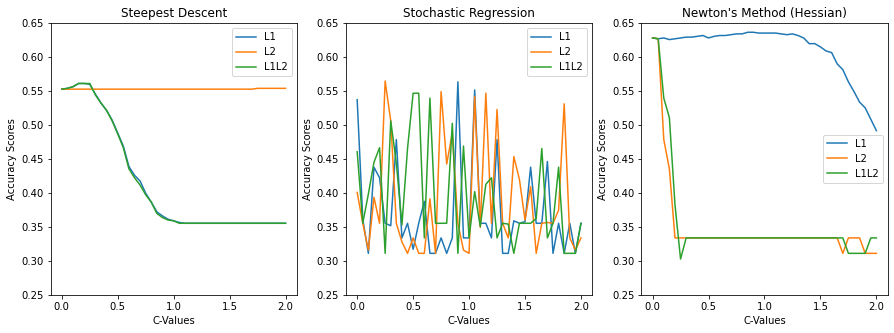

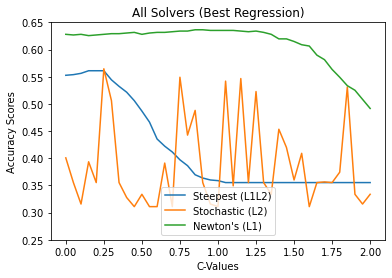

In [25]:
import matplotlib.pyplot as plt



plt.subplots(figsize=(15, 5))
plt.subplot(1,3,1)
steepL1 = plt.plot( Cs, results[0][:,0], label="L1")
steepL2 = plt.plot(Cs, results[0][:,1], label ='L2')
steepL1L2 = plt.plot(Cs, results[0][:,2], label='L1L2')
plt.legend()
plt.title("Steepest Descent")
plt.xlabel("C-Values")
plt.ylabel("Accuracy Scores")
plt.ylim(0.25, 0.65)
plt.subplot(1,3,2)
stochL1 = plt.plot( Cs, results[1][:,0], label="L1")
stochL2 = plt.plot(Cs, results[1][:,1], label ='L2')
stochL1L2 = plt.plot(Cs, results[1][:,2], label='L1L2')
plt.legend()
plt.title("Stochastic Regression")
plt.xlabel("C-Values")
plt.ylabel("Accuracy Scores")
plt.ylim(0.25, 0.65)
plt.subplot(1,3,3)
newtonL1 = plt.plot( Cs, results[2][:,0], label="L1")
newtonL2 = plt.plot(Cs, results[2][:,1], label ='L2')
newtonL1L2 = plt.plot(Cs, results[2][:,2], label='L1L2')
plt.legend()
plt.title("Newton's Method (Hessian)")
plt.xlabel("C-Values")
plt.ylabel("Accuracy Scores")
plt.ylim(0.25, 0.65)

plt.figure()
steepBest1 = plt.plot( Cs, results[0][:,2], label="Steepest (L1L2)")
stochBest = plt.plot(Cs, results[1][:,1], label ='Stochastic (L2)')
newtonBest = plt.plot(Cs, results[2][:,0], label='Newton\'s (L1)')
plt.legend()
plt.title("All Solvers (Best Regression)")
plt.xlabel("C-Values")
plt.ylabel("Accuracy Scores")
plt.ylim(0.25, 0.65)

In [253]:
np.seterr(divide = 'ignore') 
lr = CustomLogisiticRegressionWrapper(eta=0.1,iterations=100,solver='steepest', cost=0, reg='L2')
lr.fit(X_train,y_train)
lr

In [254]:
from sklearn.metrics import accuracy_score

yhat = lr.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))
#yhat

Accuracy of:  0.5358851674641149


In [192]:
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
# from sklearn.datasets import load_iris
# ds = load_iris()
# X = ds.data
# y = ds.target
lr_sk = SKLogisticRegression(solver='liblinear', max_iter=5000) # all params default

lr_sk.fit(X_train,y_train)
yhat = lr_sk.predict(X_test)
print('Accuracy of: ',accuracy_score(y_test,yhat))

Accuracy of:  0.6232057416267942


In [96]:

np.set_printoptions(threshold=np.inf)

,Length,Diameter,Height,Whole-Weight,Shucked-Weight,Viscera-Weight,Shell-Weight,Female,Infant,Male
0,0.513514,0.521008,0.084071,0.181335,0.150303,0.132324,0.147982,0,0,1
1,0.371622,0.352941,0.079646,0.079157,0.066241,0.063199,0.068261,0,0,1
2,0.614865,0.613445,0.119469,0.239065,0.171822,0.185648,0.207773,1,0,0
3,0.493243,0.521008,0.110619,0.182044,0.144250,0.149440,0.152965,0,0,1
4,0.344595,0.336134,0.070796,0.071897,0.059516,0.051350,0.053313,0,1,0
...,...,...,...,...,...,...,...,...,...,...
4172,0.662162,0.663866,0.146018,0.313441,0.248151,0.314022,0.246637,1,0,0
4173,0.695946,0.647059,0.119469,0.341420,0.294553,0.281764,0.258097,0,0,1
4174,0.709459,0.705882,0.181416,0.415796,0.352724,0.377880,0.305431,0,0,1
4175,0.743243,0.722689,0.132743,0.386931,0.356422,0.342989,0.293473,1,0,0


## Deployment

## Exceptional Work